In [5]:

import numpy as np
import cleandata
import stockenv 
import sys
import pandas as pd
import warnings
import agentperform
import torch
import torch.nn as nn

from agents import DQN, DDQN

pwd = "C:/programming/MADDQN"
sys.path.append(pwd)

# Input Data Location, File Name, Stock name for labels
import_path = pwd + "/input_data"

# Output Path Location for CSV export
export_path = pwd + "/output_data"

# Check if CUDA (GPU support) is available
if torch.cuda.is_available():
    # Get the current device
    device = torch.cuda.current_device()
    print(f"GPU Name: {torch.cuda.get_device_name(device)}")
else:
    device = 'cpu'
    print("CUDA (GPU support) is not available. PyTorch is running on CPU.")


stock_inputs ={'DJI':'^DJI_daily.csv',
               'NDAQ': '^IXIC_daily.csv',
               'SP500': '^SPX_daily.csv',
               'AAPL': 'AAPL_daily.csv',
               'AMZN': 'AMZN_daily.csv',
               'GOOGL': 'GOOGL_daily.csv',
               'MSFT': 'MSFT_daily.csv',
               'SINE': 'sine_wave_daily.csv'}

# Training Inputs
trn_keys = ['DJI','NDAQ','SP500']
training_range = (0,2500)

ALPHA = 0.1
GAMMA = 0.9

# Testing Inputs
tst_keys = ['AMZN','AAPL','GOOGL','MSFT']
testing_range = (2500,2850)

environments = {}

for name, file in stock_inputs.items():
    temp_df = cleandata.YAHOO_csv_input(file,import_path)
    temp_norm_df = cleandata.normalize_df_ohlcv_by_row_range(temp_df,training_range[0],training_range[1])
    environments[name] = stockenv.ContinuousOHLCVEnv(name,ohlcv_data=temp_norm_df.to_numpy(),
                                  stock_price_data=temp_df['close'].to_numpy(),
                                  commission_rate=0.005)


# Define a reward function outside the Environment class
def norm_6sig_1min(norm_num):
    """
    Function used to help division of normalized values (mean = 0).
    Input numbers close to zero outputs around 1, maintains input of -6:-2 to output 
    approx 6,2 (same for inputs 2:6). 6 standard deviations is approx 99.9999998%
    
    """
    result = np.exp(1.99*np.sin(0.59*(np.abs(norm_num) / np.pi)))
    if norm_num < -6.0 or norm_num > 6.0:
        warnings.warn(f'Input ({norm_num:.2f}) is outside of six standard deviations, output explodes exponentially')
    return result
 
def return_reward(env):
    n = 33 # How many days in the future
    
    
    current_price = norm_6sig_1min(env.ohlcv_raw_data[env.current_step,3])
    
    # Check if there are enough elements for the future prices
    if len(env.ohlcv_raw_data) < env.current_step + n:
        raise ValueError("Not enough OHLCV data for the future prices")
    
    tomorrows_price = norm_6sig_1min(env.ohlcv_raw_data[env.current_step:env.current_step+n,3].mean())
    position = env.position
    reward = (((tomorrows_price - current_price)/current_price))*position
    
    opp_cost = 0.0002*(1-position)*n # Assuming risk-free return of 5% / 252 trading days
    
    return 100*(reward - opp_cost)

def risk_reward(env):
    """
    Calculate the risk-reward ratio based on historical price data and current position in the environment.

    Args:
    - env: Environment object containing OHLCV raw data and position information.

    Returns:
    - float: Risk-reward ratio.
    """
    n = 33  # How many days in the future

    current_price = env.ohlcv_raw_data[env.current_step, 3]
    
    # Check if there are enough elements for the future prices
    if len(env.ohlcv_raw_data) < env.current_step + n:
        raise ValueError("Not enough OHLCV data for the future prices")
    
    tomorrows_price = env.ohlcv_raw_data[env.current_step:env.current_step+n, 3]
    position = env.position
    
    rewards = (tomorrows_price - current_price) / current_price
    
    rewards_mean = np.mean(rewards)  # Calculate mean using NumPy's mean function
    rewards_std = np.std(rewards)  # Calculate standard deviation using NumPy's std function
    
    
    
    return (rewards_mean / rewards_std) * position
   
    
    

def linear_decay(initial_epsilon, final_epsilon, current_epoch, total_epochs):
    if initial_epsilon == final_epsilon:
        return initial_epsilon
    elif total_epochs == 1:
        return final_epsilon
    else:
        rate_of_change = (final_epsilon - initial_epsilon) / (total_epochs-1)
        current_epsilon = np.round((initial_epsilon - rate_of_change) + (rate_of_change * current_epoch),3)
        
        if current_epsilon > initial_epsilon or current_epsilon < final_epsilon:
            raise ValueError(f'Epsilon value ({current_epsilon}) out of valid range ({initial_epsilon}:{final_epsilon})')
    
        return current_epsilon 


CUDA (GPU support) is not available. PyTorch is running on CPU.


c:\Users\beckm\anaconda3\envs\MADDQN\Lib\site-packages\gymnasium\spaces\box.py:130: UserWarning: WARN: Box bound precision lowered by casting to float32
  gym.logger.warn(f"Box bound precision lowered by casting to {self.dtype}")
c:\Users\beckm\anaconda3\envs\MADDQN\Lib\site-packages\gymnasium\spaces\box.py:130: UserWarning: WARN: Box bound precision lowered by casting to float32
  gym.logger.warn(f"Box bound precision lowered by casting to {self.dtype}")
c:\Users\beckm\anaconda3\envs\MADDQN\Lib\site-packages\gymnasium\spaces\box.py:130: UserWarning: WARN: Box bound precision lowered by casting to float32
  gym.logger.warn(f"Box bound precision lowered by casting to {self.dtype}")
c:\Users\beckm\anaconda3\envs\MADDQN\Lib\site-packages\gymnasium\spaces\box.py:130: UserWarning: WARN: Box bound precision lowered by casting to float32
  gym.logger.warn(f"Box bound precision lowered by casting to {self.dtype}")
c:\Users\beckm\anaconda3\envs\MADDQN\Lib\site-packages\gymnasium\spaces\box.py:1

In [6]:
best_ddqn_agent = DDQN(name="risk_agent",
                    environment=None,
                    reward_function=return_reward,
                    input_size= 6, 
                    hidden_size=256, 
                    output_size=3, 
                    activation_function = nn.Tanh(),
                    num_hidden_layers = 1,                  
                    buffer_size=800, 
                    batch_size=140,
                    opt_lr= 0.0005,
                    alpha = ALPHA,
                    gamma = GAMMA,
                    opt_wgt_dcy = 0.0,
                    dropout_rate = 0.25,                    
                    device = device)




for key, env in environments.items():
  
        env.add_agent(best_ddqn_agent.get_name())
        env.set_decision_agent(best_ddqn_agent.get_name())



DJI ENV: Agent risk_agent added
DJI ENV: Agent risk_agent assigned as decision agent
NDAQ ENV: Agent risk_agent added
NDAQ ENV: Agent risk_agent assigned as decision agent
SP500 ENV: Agent risk_agent added
SP500 ENV: Agent risk_agent assigned as decision agent
AAPL ENV: Agent risk_agent added
AAPL ENV: Agent risk_agent assigned as decision agent
AMZN ENV: Agent risk_agent added
AMZN ENV: Agent risk_agent assigned as decision agent
GOOGL ENV: Agent risk_agent added
GOOGL ENV: Agent risk_agent assigned as decision agent
MSFT ENV: Agent risk_agent added
MSFT ENV: Agent risk_agent assigned as decision agent
SINE ENV: Agent risk_agent added
SINE ENV: Agent risk_agent assigned as decision agent


In [7]:
for key, env in environments.items():
    if key in trn_keys:
        
        best_ddqn_agent.set_environment(env)
        best_ddqn_agent.train(start_idx=training_range[0],
                    end_idx=training_range[1],
                    training_epsidoes= 5,
                    epsilon_decya_func= linear_decay,
                    initial_epsilon= 0.9,
                    final_epsilon= 0.1,
                    update_q_freq= 3,
                    update_tgt_freq= 20)

        ddqn_trn = best_ddqn_agent.get_training_episodic_data()

        display(ddqn_trn)

risk_agent: Training Initialized on DJI[0:2500]
risk_agent: EPIDSODE 5 of 5 Finished -> Q1 Loss = 1.08, Q2 Loss = 0.95, Total Reward = 517.14 Mean Reward = 0.21, STD Reward = 3.61
risk_agent: Training finished on DJI[0:2500]


,Training Episode,Total Reward,Mean Reward,STD Reward,Q1 Loss,Q2 Loss,Epsilon
0,1,24.072379,0.009629,3.584567,0.597418,0.612882,0.9
1,2,95.265677,0.038106,3.876780,0.741642,0.710503,0.7
2,3,39.460734,0.015784,3.588828,0.742389,0.714096,0.5
3,4,286.802785,0.114721,3.905883,1.105903,0.938496,0.3
4,5,517.137434,0.206855,3.612431,1.079395,0.952015,0.1


risk_agent: Training Initialized on NDAQ[0:2500]
risk_agent: EPIDSODE 5 of 5 Finished -> Q1 Loss = 0.72, Q2 Loss = 0.95, Total Reward = 437.80 Mean Reward = 0.18, STD Reward = 2.9283
risk_agent: Training finished on NDAQ[0:2500]


,Training Episode,Total Reward,Mean Reward,STD Reward,Q1 Loss,Q2 Loss,Epsilon
0,1,-451.469825,-0.180588,2.667443,0.498199,0.520217,0.9
1,2,-176.606262,-0.070643,2.825173,0.707148,0.629981,0.7
2,3,125.373611,0.050149,2.936285,0.871699,0.761830,0.5
3,4,223.246128,0.089298,2.959826,0.833146,0.661624,0.3
4,5,437.802796,0.175121,2.918165,0.723136,0.952363,0.1


risk_agent: Training Initialized on SP500[0:2500]
risk_agent: EPIDSODE 5 of 5 Finished -> Q1 Loss = 0.98, Q2 Loss = 0.84, Total Reward = 504.76 Mean Reward = 0.20, STD Reward = 3.1684
risk_agent: Training finished on SP500[0:2500]


,Training Episode,Total Reward,Mean Reward,STD Reward,Q1 Loss,Q2 Loss,Epsilon
0,1,-225.397085,-0.090159,3.135505,0.575589,0.484795,0.9
1,2,21.718206,0.008687,3.181253,0.677600,0.598849,0.7
2,3,-62.542206,-0.025017,3.180242,0.719136,0.751876,0.5
3,4,392.419615,0.156968,3.152312,0.867795,0.768149,0.3
4,5,504.758413,0.201903,3.159901,0.981822,0.839989,0.1


risk_agent: Testing Initialized on AAPL[2500:2850]
risk_agent - AAPL[2500:2850] - Testing Finished - EPIDSODE - 1 of 1-> Total Reward = 1069.05, Mean Reward = 3.05STD Reward = 5.53
risk_agent: Testing Complete on AAPL[2500:2850]


,Step,idx,Portfolio Value,Cash,Stock Value,Stock Holdings,Stock Price,Last Commission Cost,Total Commision Cost,State,Available Actions,Env Action,risk_agent Action,risk_agent Action Type,risk_agent Q_Val Sell,risk_agent Q_Val Hold,risk_agent Q_Val Buy,risk_agent Reward
0,1,2500,100000.00000,100000.00000,0.00,0,27.49,0.00000,0.00000,"[1.3386717176598355, 1.336080041090117, 1.3588...","(H, B)",B,B,Best,9.700319,9.931912,11.673873,7.083462
1,2,2501,100499.90565,518.77565,100963.12,3637,27.76,499.90565,499.90565,"[1.332027398575922, 1.3591684423016857, 1.3577...","(S, H)",H,H,Best,10.586036,11.143704,11.973358,6.312009
2,3,2502,101481.89565,518.77565,101945.11,3637,28.03,0.00000,499.90565,"[1.3763228591353474, 1.3932513202806676, 1.397...","(S, H)",H,H,Best,10.268081,10.742296,11.632145,5.515915
3,4,2503,102463.88565,518.77565,103618.13,3637,28.49,0.00000,499.90565,"[1.4161887736388303, 1.4548203901781838, 1.445...","(S, H)",H,H,Best,10.124946,10.558938,11.501898,3.903254
4,5,2504,104136.90565,518.77565,103036.21,3637,28.33,0.00000,499.90565,"[1.4427660499744859, 1.4636159715921144, 1.450...","(S, H)",H,H,Best,9.935273,10.327877,11.286084,4.809435
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
345,346,2845,151199.68565,518.77565,150244.47,3637,41.31,0.00000,499.90565,"[2.9255565922012576, 2.8906990560023957, 2.890...","(S, H)",H,H,Best,7.586842,7.824214,8.972404,16.212006
346,347,2846,150763.24565,518.77565,148171.38,3637,40.74,0.00000,499.90565,"[2.893442383295674, 2.874207340851276, 2.81105...","(S, H)",H,H,Best,7.598464,7.833750,8.984081,19.389589
347,348,2847,148690.15565,518.77565,148789.67,3637,40.91,0.00000,499.90565,"[2.8081736217187796, 2.848920044286225, 2.8434...","(S, H)",H,H,Best,7.586592,7.823701,8.970804,19.515546
348,349,2848,149308.44565,518.77565,149335.22,3637,41.06,0.00000,499.90565,"[2.850254309250234, 2.8577156257001555, 2.8702...","(S, H)",H,H,Best,7.577268,7.815996,8.961071,19.736306


c:\Users\beckm\anaconda3\envs\MADDQN\Lib\site-packages\quantstats\stats.py:349: RuntimeWarning: divide by zero encountered in scalar divide
  res = returns.mean() / downside


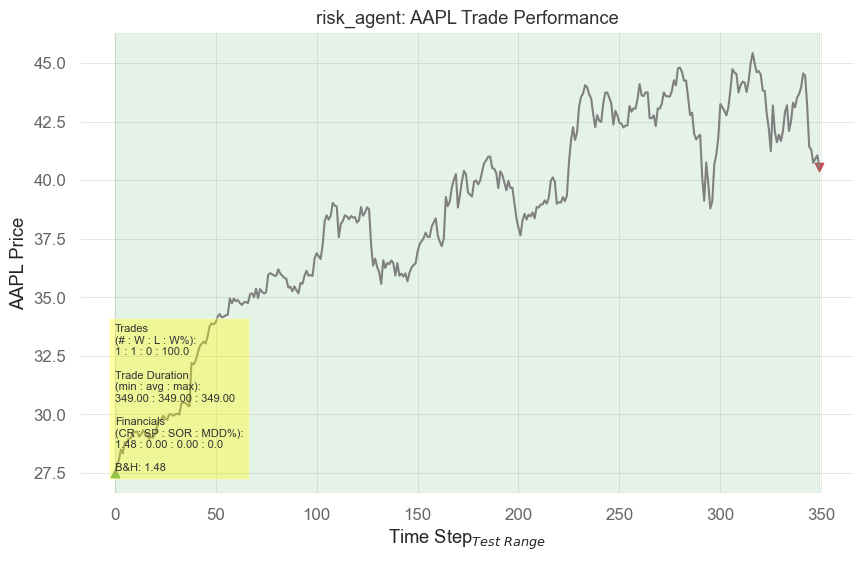

risk_agent: Testing Initialized on AMZN[2500:2850]
risk_agent - AMZN[2500:2850] - Testing Finished - EPIDSODE - 1 of 1-> Total Reward = 1687.82, Mean Reward = 4.82STD Reward = 5.78
risk_agent: Testing Complete on AMZN[2500:2850]


C:\Users\beckm\AppData\Local\Temp\ipykernel_12832\286162245.py:72: UserWarning: Input (6.01) is outside of six standard deviations, output explodes exponentially
  warnings.warn(f'Input ({norm_num:.2f}) is outside of six standard deviations, output explodes exponentially')
C:\Users\beckm\AppData\Local\Temp\ipykernel_12832\286162245.py:72: UserWarning: Input (6.05) is outside of six standard deviations, output explodes exponentially
  warnings.warn(f'Input ({norm_num:.2f}) is outside of six standard deviations, output explodes exponentially')
C:\Users\beckm\AppData\Local\Temp\ipykernel_12832\286162245.py:72: UserWarning: Input (6.09) is outside of six standard deviations, output explodes exponentially
  warnings.warn(f'Input ({norm_num:.2f}) is outside of six standard deviations, output explodes exponentially')
C:\Users\beckm\AppData\Local\Temp\ipykernel_12832\286162245.py:72: UserWarning: Input (6.13) is outside of six standard deviations, output explodes exponentially
  warnings.warn(

,Step,idx,Portfolio Value,Cash,Stock Value,Stock Holdings,Stock Price,Last Commission Cost,Total Commision Cost,State,Available Actions,Env Action,risk_agent Action,risk_agent Action Type,risk_agent Q_Val Sell,risk_agent Q_Val Hold,risk_agent Q_Val Buy,risk_agent Reward
0,1,2500,100000.000,100000.000,0.00,0,38.24,0.000,0.000,"[2.6040991362575934, 2.591707938947714, 2.6088...","(H, B)",B,B,Best,7.892726,8.088339,9.410003,2.753261
1,2,2501,100499.988,502.388,100729.80,2615,38.52,499.988,499.988,"[2.6071699451124326, 2.602886501845049, 2.6016...","(S, H)",H,H,Best,7.973062,8.160558,9.386831,2.158836
2,3,2502,101232.188,502.388,100337.55,2615,38.37,0.000,499.988,"[2.64401965137051, 2.620162462686383, 2.650203...","(S, H)",H,H,Best,7.900287,8.095004,9.307882,3.035041
3,4,2503,100839.938,502.388,100494.45,2615,38.43,0.000,499.988,"[2.6348072248059906, 2.6018702688543813, 2.651...","(S, H)",H,H,Best,7.833364,8.035552,9.233931,3.183293
4,5,2504,100996.838,502.388,99396.15,2615,38.01,0.000,499.988,"[2.616382371676952, 2.5845943080130476, 2.6088...","(S, H)",H,H,Best,7.908100,8.102005,9.314157,4.985078
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
345,346,2845,200209.938,502.388,198452.35,2615,75.89,0.000,499.988,"[6.609457485920242, 6.554000369557348, 6.46282...","(S, H)",H,H,Best,7.340331,7.600008,8.707302,4.638232
346,347,2846,198954.738,502.388,190895.00,2615,73.00,0.000,499.988,"[6.554182926533127, 6.510302350958677, 6.17875...","(S, H)",H,H,Best,7.358863,7.629667,8.727108,9.361491
347,348,2847,191397.388,502.388,190921.15,2615,73.01,0.000,499.988,"[6.1560013783555725, 6.157669503197318, 6.0062...","(S, H)",H,H,Best,7.359168,7.629876,8.727163,9.741487
348,349,2848,191423.538,502.388,198478.50,2615,75.90,0.000,499.988,"[6.29418777682336, 6.459490701425341, 6.334734...","(S, H)",H,H,Best,7.361712,7.633167,8.731039,5.673779


c:\Users\beckm\anaconda3\envs\MADDQN\Lib\site-packages\quantstats\stats.py:349: RuntimeWarning: invalid value encountered in scalar divide
  res = returns.mean() / downside


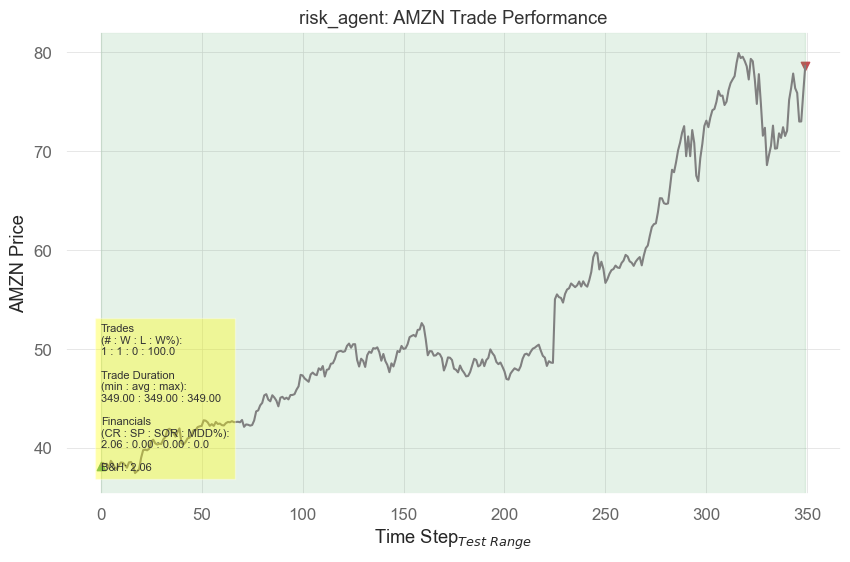

risk_agent: Testing Initialized on GOOGL[2500:2850]
risk_agent - GOOGL[2500:2850] - Testing Finished - EPIDSODE - 1 of 1-> Total Reward = 807.02, Mean Reward = 2.31STD Reward = 5.81
risk_agent: Testing Complete on GOOGL[2500:2850]


,Step,idx,Portfolio Value,Cash,Stock Value,Stock Holdings,Stock Price,Last Commission Cost,Total Commision Cost,State,Available Actions,Env Action,risk_agent Action,risk_agent Action Type,risk_agent Q_Val Sell,risk_agent Q_Val Hold,risk_agent Q_Val Buy,risk_agent Reward
0,1,2500,100000.0000,100000.0000,0.00,0,38.81,0.0000,0.0000,"[2.0940716512420585, 2.090494043542701, 2.0939...","(H, B)",B,B,Best,8.170306,8.326350,9.703306,7.600983
1,2,2501,100499.8728,525.3128,101932.32,2576,39.57,499.8728,499.8728,"[2.092980451507834, 2.127390213975625, 2.09506...","(S, H)",H,H,Best,8.321364,8.492668,9.716925,5.051424
2,3,2502,102457.6328,525.3128,102421.76,2576,39.76,0.0000,499.8728,"[2.1639084342324164, 2.1653715658918697, 2.174...","(S, H)",H,H,Best,8.174588,8.351741,9.566342,4.690814
3,4,2503,102947.0728,525.3128,104250.72,2576,40.47,0.0000,499.8728,"[2.1988268257275956, 2.22505654747454, 2.22917...","(S, H)",H,H,Best,8.142860,8.320525,9.538469,2.238168
4,5,2504,104776.0328,525.3128,104070.40,2576,40.40,0.0000,499.8728,"[2.228289218551653, 2.232652817857789, 2.26544...","(S, H)",H,H,Best,8.080716,8.262527,9.473833,2.587597
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
345,346,2845,139294.4328,525.3128,138305.44,2576,53.69,0.0000,499.8728,"[3.7461480488577155, 3.733458809291115, 3.7054...","(S, H)",H,H,Best,7.474156,7.735093,8.856390,0.685047
346,347,2846,138830.7528,525.3128,131710.88,2576,51.13,0.0000,499.8728,"[3.616295280485019, 3.605407394259204, 3.40976...","(S, H)",H,H,Best,7.648525,7.882052,9.067302,9.591539
347,348,2847,132236.1928,525.3128,131762.40,2576,51.15,0.0000,499.8728,"[3.4558889195540403, 3.4513116236275825, 3.432...","(S, H)",H,H,Best,7.507074,7.760854,8.891504,10.132351
348,349,2848,132287.7128,525.3128,134389.92,2576,52.17,0.0000,499.8728,"[3.4744393150358537, 3.5381261422932857, 3.451...","(S, H)",H,H,Best,7.484063,7.742136,8.865367,7.180354


c:\Users\beckm\anaconda3\envs\MADDQN\Lib\site-packages\quantstats\stats.py:349: RuntimeWarning: divide by zero encountered in scalar divide
  res = returns.mean() / downside


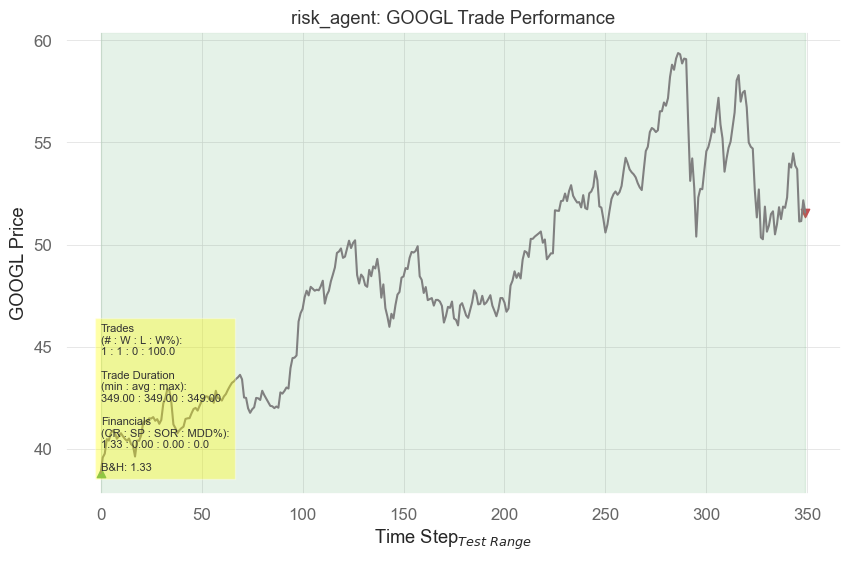

risk_agent: Testing Initialized on MSFT[2500:2850]
risk_agent - MSFT[2500:2850] - Testing Finished - EPIDSODE - 1 of 1-> Total Reward = 1397.65, Mean Reward = 3.99STD Reward = 4.28
risk_agent: Testing Complete on MSFT[2500:2850]


C:\Users\beckm\AppData\Local\Temp\ipykernel_12832\286162245.py:72: UserWarning: Input (6.09) is outside of six standard deviations, output explodes exponentially
  warnings.warn(f'Input ({norm_num:.2f}) is outside of six standard deviations, output explodes exponentially')
C:\Users\beckm\AppData\Local\Temp\ipykernel_12832\286162245.py:72: UserWarning: Input (6.11) is outside of six standard deviations, output explodes exponentially
  warnings.warn(f'Input ({norm_num:.2f}) is outside of six standard deviations, output explodes exponentially')
C:\Users\beckm\AppData\Local\Temp\ipykernel_12832\286162245.py:72: UserWarning: Input (6.01) is outside of six standard deviations, output explodes exponentially
  warnings.warn(f'Input ({norm_num:.2f}) is outside of six standard deviations, output explodes exponentially')
C:\Users\beckm\AppData\Local\Temp\ipykernel_12832\286162245.py:72: UserWarning: Input (6.03) is outside of six standard deviations, output explodes exponentially
  warnings.warn(

,Step,idx,Portfolio Value,Cash,Stock Value,Stock Holdings,Stock Price,Last Commission Cost,Total Commision Cost,State,Available Actions,Env Action,risk_agent Action,risk_agent Action Type,risk_agent Q_Val Sell,risk_agent Q_Val Hold,risk_agent Q_Val Buy,risk_agent Reward
0,1,2500,100000.000,100000.000,0.00,0,59.95,0.000,0.000,"[2.5902376821364523, 2.5479575049647525, 2.571...","(H, B)",B,B,Best,7.629527,7.847260,9.050657,8.830111
1,2,2501,100499.983,503.383,102365.16,1668,61.37,499.983,499.983,"[2.5494237968408844, 2.6369058926901885, 2.571...","(S, H)",H,H,Best,7.813623,8.018219,9.210739,4.364130
2,3,2502,102868.543,503.383,101764.68,1668,61.01,0.000,499.983,"[2.6747807302487003, 2.656242498717457, 2.6733...","(S, H)",H,H,Best,7.651275,7.877816,9.037021,5.858271
3,4,2503,102268.063,503.383,103365.96,1668,61.97,0.000,499.983,"[2.663119620164253, 2.695882541073358, 2.70169...","(S, H)",H,H,Best,7.704530,7.923423,9.096008,3.146466
4,5,2504,103869.343,503.383,103699.56,1668,62.17,0.000,499.983,"[2.725312207281309, 2.7258542804156236, 2.7592...","(S, H)",H,H,Best,7.603522,7.837587,8.987267,2.804679
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
345,346,2845,158963.383,503.383,159043.80,1668,95.35,0.000,499.983,"[6.021519324485287, 6.0121104747499325, 5.9713...","(S, H)",H,H,Best,7.332700,7.589486,8.700758,2.775170
346,347,2846,159547.183,503.383,155324.16,1668,93.12,0.000,499.983,"[6.070107283170487, 6.029513420174474, 5.75472...","(S, H)",H,H,Best,7.347676,7.613564,8.715064,6.899070
347,348,2847,155827.543,503.383,153973.08,1668,92.31,0.000,499.983,"[5.78441008610151, 5.723028214642265, 5.546825...","(S, H)",H,H,Best,7.351499,7.619578,8.718955,8.783979
348,349,2848,154476.463,503.383,157225.68,1668,94.26,0.000,499.983,"[5.80870406544411, 5.901891820394501, 5.822066...","(S, H)",H,H,Best,7.353978,7.622549,8.721428,5.657954


c:\Users\beckm\anaconda3\envs\MADDQN\Lib\site-packages\quantstats\stats.py:349: RuntimeWarning: divide by zero encountered in scalar divide
  res = returns.mean() / downside


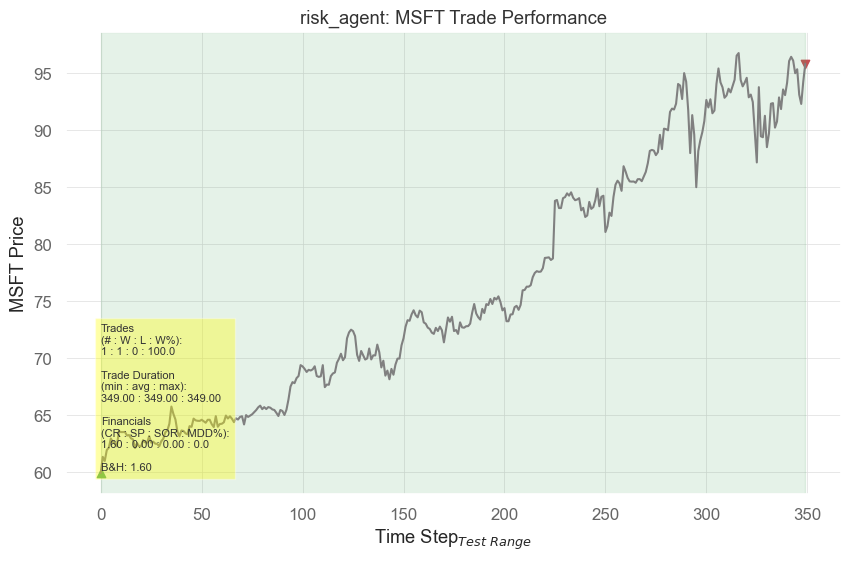

In [8]:
for key, env in environments.items():
    
    if key in tst_keys:

        best_ddqn_agent.set_environment(env)    
        best_ddqn_agent.test(start_idx = testing_range[0],
                       end_idx = testing_range[1], 
                       testing_epsidoes=1)

        a = env.get_step_data()
        b = best_ddqn_agent.get_step_data()
        combined_df = pd.concat([a,b],axis=1)
        display(combined_df)
        d = best_ddqn_agent.get_testing_episodic_data()
        agentperform.agent_stock_performance(env.stock_price_data[testing_range[0]:testing_range[1]],
                                            combined_df['Env Action'].to_numpy(),
                                            key,
                                            best_ddqn_agent.get_name(),
                                            display_graph=True,
                                            save_graphic=False,
                                            path_file=None)
